In [ ]:
# Use MNIST handwriting digits image data. The Discriminator with be given an image 
# from the MNIST dataset or a latent sample. Initially latent sample is a random matrix 
# that the Generator uses to construct its fake images.  
# 
# A Discriminator can be discurded after training if the goal is to generate new images. 
# We will use PyTorch to define GANs and generate new images
# This example is based on the original paper introduing GANs 
# https://arxiv.org/abs/1406.2661
# Paper repo: https://github.com/goodfeli/adversarial
# Code is a modification of the exmaple in Udacity course 

In [10]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms


In [11]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

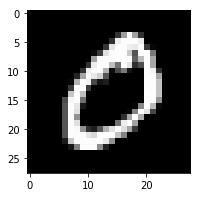

In [12]:
# take one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# take 2nd (or any!) image from the batch - 28 x 28 pixels
img = np.squeeze(images[1])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F# create the generator  with tanh output [-1 1]

# Start with the Discriminator as we can think about the available image
# and ints dimensions 28 * 28 = 784 
#
# Discriminator will use leaky ReLU to allow gradients to flow backwards 
# through the layers. A leaky ReLU is similar to the standard ReLU, but 
# that there is a reduced value for negative input.
#      https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU
# Discriminator needs to produce a Sigmoid Output
# as it should output a value [0 1] for fake or real image.
# Remember that Generator will enlarge the size of its output and Discriminator 
# will reduce the size

class Discriminator(nn.Module):

    # input_size 28*28, hidden_dim - output from the final hidden layer
    # output_size - how many outputs to produce
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define 3 hidden linear layers
        # start with 784 -> 128 -> 64 -> 32
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, xx):
        # flatten image xx - true or fake image is 28 x 28 pixels
        xx = xx.view(-1, 28*28)
        # all hidden layers have a Leaky ReLu activation function applied to their output
        xx = F.leaky_relu(self.fc1(xx), 0.2) # (input, negative_slope=0.2) # reduced to 20% of original value
        xx = self.dropout(xx)
        xx = F.leaky_relu(self.fc2(xx), 0.2)
        xx = self.dropout(xx)
        xx = F.leaky_relu(self.fc3(xx), 0.2)
        xx = self.dropout(xx)
        # final output layer should not have any activation function applied to it
        out = self.fc4(xx)  # one numeric value
        # we will apply BCE with logits loss when we compute loss
        
        return out


In [20]:
# Generator is the same only has the tanh applied to the output
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define 3 hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, xx):
        # all hidden layers have a Leaky ReLu activation function applied to their output
        xx = F.leaky_relu(self.fc1(xx), 0.2) # (input, negative_slope=0.2)
        xx = self.dropout(xx)
        xx = F.leaky_relu(self.fc2(xx), 0.2)
        xx = self.dropout(xx)
        xx = F.leaky_relu(self.fc3(xx), 0.2)
        xx = self.dropout(xx)
        # final layer with tanh applied (not ReLU) - scale output [-1 1]
        out = F.tanh(self.fc4(xx)) 

        return out

In [21]:
# Set up model parameters

# Discriminator hyperparams
# Size of input image to discriminator 28*28 
input_size = 784
# Size of discriminator output (real or fake), 1 value
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams
# Size of latent vector to give to generator - any size
# will be transformed according to the set up above:
#       self.fc1 = nn.Linear(input_size, hidden_dim)
#       self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
#       self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
#       # final fully-connected layer
#       self.fc4 = nn.Linear(hidden_dim*4, output_size)
# which are 32 (hidden_dim), 64, 128 and finally to 784
z_size = 100
# Size of generator output (generated image) 28*28 
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32


In [22]:
# instantiate generator and discriminator 
G = Generator(z_size, g_hidden_size, g_output_size)
D = Discriminator(input_size, d_hidden_size, d_output_size)

# check that they are as you expect
print(D) # check that D is downsampling to 1 value
print()
print(G) # G is the reverce produces original size image

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [23]:
# D will have 2 losses, one for real and one for fake images
# All real should be labeled close to 1 and fake ones close to 0

# Calculate losses
def real_loss(D_out, smooth=False):
    # how many output values do we have?
    batch_size = D_out.size(0)
    # create 'true' labels 
    # if using smoothing will reduce to .9
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss, sqweeze removes any empty dimentions
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # similar to above, no smoothing ans using torch.zeros()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # function definition
    # https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [24]:
import torch.optim as optim

# Optimizers 
# should be updated separatly, so define two separate Adam optimizers
lr = 0.002 # learning rate

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [26]:
# TRAINING
# Discriminator training
#   Compute the discriminator loss on real images, true labels will be smoothed
#   Generate fake images
#   Compute the discriminator loss on fake images
#   Add real and fake loss to get D loss
#   Perform backpropagation & an optimization step to update the discriminator's weights
#
# Generator training
#   Generate fake images
#   Compute the discriminator loss on fake images, using flipped labels!
#   Perform backpropagation & an optimization step to update the generator's weights
#   No label smoothing here

import pickle as pkl # to save some fake images as we train...

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" images
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # Rescale image to [-1 1] as we will work with tanh applied to 
        # the output of the generator
        real_images = real_images*2 - 1 # rescale input images from [0,1] to [-1, 1]
        
        ## train the discriminator
        d_optimizer.zero_grad() # eliminate any accumulated gradient
        
        # train on real images
        # compute D losses on real images smooth real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # train with fake images - generate 
        zz = np.random.uniform(-1, 1, size=(batch_size, z_size))
        zz = torch.from_numpy(zz).float()
        fake_images = G(zz)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step() # update d optimiser steps
        
        
        # train the Generator
        g_optimizer.zero_grad()
        
        # Why are we regenerating the fake image - do we avoid bias?
        # train with fake images and flipped labels
        # Generate fake images
        # Uniformly distributed on [-1 1], batch_size # of fake images
        # of size z_size
        zz = np.random.uniform(-1, 1, size=(batch_size, z_size))
        zz = torch.from_numpy(zz).float()
        fake_images = G(zz)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        # as G wants to be as close to 1 as possible - adversarial loss
        
        # perform backpropagation
        g_loss.backward()
        g_optimizer.step()

        # print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    # after each epoch
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3865 | g_loss: 0.6518
Epoch [    1/  100] | d_loss: 1.2798 | g_loss: 1.7173
Epoch [    1/  100] | d_loss: 1.4701 | g_loss: 0.7803
Epoch [    2/  100] | d_loss: 1.1761 | g_loss: 1.1884
Epoch [    2/  100] | d_loss: 1.0088 | g_loss: 1.1105
Epoch [    2/  100] | d_loss: 1.1829 | g_loss: 0.9031
Epoch [    3/  100] | d_loss: 0.9068 | g_loss: 1.1754
Epoch [    3/  100] | d_loss: 0.8569 | g_loss: 1.4027
Epoch [    3/  100] | d_loss: 0.8656 | g_loss: 1.6398
Epoch [    4/  100] | d_loss: 0.9931 | g_loss: 1.1881
Epoch [    4/  100] | d_loss: 1.2898 | g_loss: 0.8479
Epoch [    4/  100] | d_loss: 1.4419 | g_loss: 0.9479
Epoch [    5/  100] | d_loss: 1.5434 | g_loss: 1.0355
Epoch [    5/  100] | d_loss: 1.2509 | g_loss: 1.1706
Epoch [    5/  100] | d_loss: 1.5213 | g_loss: 0.7709
Epoch [    6/  100] | d_loss: 1.1867 | g_loss: 1.2246
Epoch [    6/  100] | d_loss: 1.0810 | g_loss: 2.9652
Epoch [    6/  100] | d_loss: 1.2183 | g_loss: 1.5610
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.3195 | g_loss: 1.0078
Epoch [   52/  100] | d_loss: 1.3370 | g_loss: 0.7788
Epoch [   52/  100] | d_loss: 1.2871 | g_loss: 1.0557
Epoch [   52/  100] | d_loss: 1.2516 | g_loss: 1.1673
Epoch [   53/  100] | d_loss: 1.3027 | g_loss: 1.0001
Epoch [   53/  100] | d_loss: 1.3100 | g_loss: 1.3330
Epoch [   53/  100] | d_loss: 1.2808 | g_loss: 1.0039
Epoch [   54/  100] | d_loss: 1.2529 | g_loss: 1.1401
Epoch [   54/  100] | d_loss: 1.3330 | g_loss: 0.9561
Epoch [   54/  100] | d_loss: 1.2528 | g_loss: 0.9744
Epoch [   55/  100] | d_loss: 1.3119 | g_loss: 1.3540
Epoch [   55/  100] | d_loss: 1.2900 | g_loss: 0.9395
Epoch [   55/  100] | d_loss: 1.3507 | g_loss: 1.0305
Epoch [   56/  100] | d_loss: 1.2607 | g_loss: 1.0343
Epoch [   56/  100] | d_loss: 1.2746 | g_loss: 0.8587
Epoch [   56/  100] | d_loss: 1.2738 | g_loss: 1.0489
Epoch [   57/  100] | d_loss: 1.2065 | g_loss: 1.2926
Epoch [   57/  100] | d_loss: 1.3505 | g_loss: 0.9303
Epoch [   57/  100] | d_loss

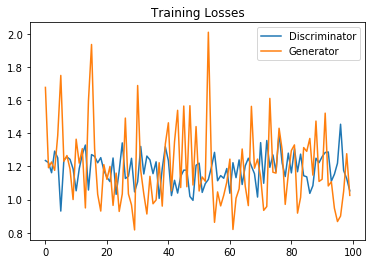

In [15]:
# plot the training losses for the generator and discriminator 
# recorded after each epoch

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend() # we get a lot of variability, D does not seem to reduce

In [16]:
# view samples of images from the generator. 
# first look at the images saved during training

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [17]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

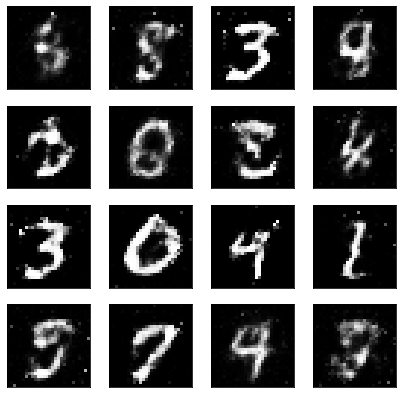

In [18]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

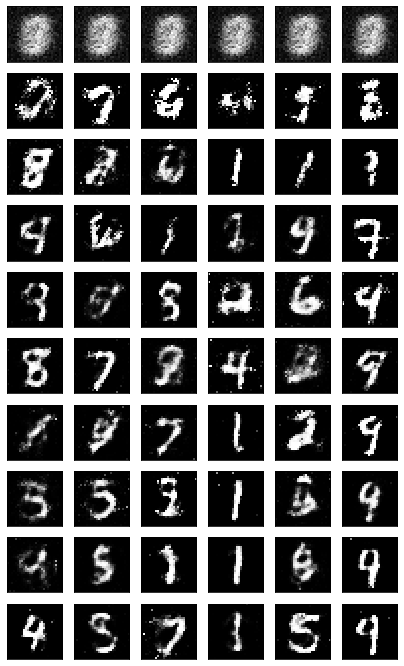

In [19]:
# plot generated images as the network was training after every 10 epochs
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

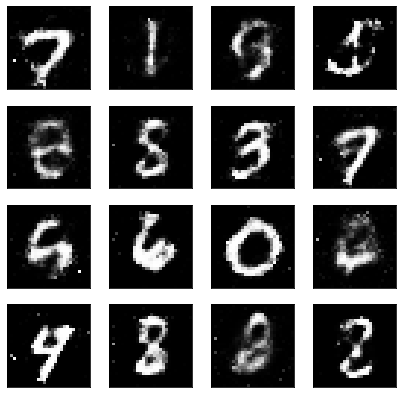

In [27]:
# Let's generate new images
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode - we are now generating new images! not training
# generate samples = pass in new random image G will prodcue a new 
# realistic looking one!
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we have one batch of samples
view_samples(0, [rand_images])